In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exercise: EDA

This exercise is a continuation of the exploratory data analysis of the Citibike Trip Histories dataset. The first section shows code to prepare the data, followed by a section of the initial analysis. Your task is complete the EDA of the Citibike dataset. The instructions are stated in the last section of this notebook.

**IMPORTANT:** Copy this notebook and make changes in that copy. Do not push changes to this notebook.

In [6]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data - CitiBike Trip Histories

CitiBike provides the data of the bike share through this website: https://www.citibikenyc.com/system-data

For this exercise, we'll be using their trip history data which may be found [here](https://s3.amazonaws.com/tripdata/index.html). 

In [7]:
data = pd.read_csv('/content/drive/MyDrive/DATA-SCI/202102-citibike-tripdata.csv')
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,304,2021-02-01 00:04:23.0780,2021-02-01 00:09:27.7920,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2
1,370,2021-02-01 00:07:08.8080,2021-02-01 00:13:19.4670,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1
2,635,2021-02-01 00:07:55.9390,2021-02-01 00:18:31.0390,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2
3,758,2021-02-01 00:08:42.0960,2021-02-01 00:21:20.7820,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0
4,522,2021-02-01 00:09:32.6820,2021-02-01 00:18:15.4100,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1


## Feature Extraction

In [8]:
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

data['dayofweek'] = data['starttime'].dt.dayofweek
data['hourofday'] = data['starttime'].dt.hour
data['year'] = data['starttime'].dt.year

## Feature Transformation

In [9]:
data['duration_min'] = data['tripduration']/60

## Feature Generation

In [10]:
data['age'] = data['starttime'].dt.year - data['birth year']
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age
0,304,2021-02-01 00:04:23.078,2021-02-01 00:09:27.792,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2,0,0,2021,5.066667,25
1,370,2021-02-01 00:07:08.808,2021-02-01 00:13:19.467,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1,0,0,2021,6.166667,30
2,635,2021-02-01 00:07:55.939,2021-02-01 00:18:31.039,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2,0,0,2021,10.583333,41
3,758,2021-02-01 00:08:42.096,2021-02-01 00:21:20.782,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0,0,0,2021,12.633333,52
4,522,2021-02-01 00:09:32.682,2021-02-01 00:18:15.410,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1,0,0,2021,8.700000,33


#### Distance

Another feature we can generate from the data is distance. Although the provided values are in longitude and latitudes and they're measured in degrees, the distance calculated from these points would also be in degrees (and not meters). 

There's actually a library that specifically handles geospatial data called `geopy` ([Link](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)). For simplicity sake in this tutorial, we use an existing function that calculates the geodesic distance using the Haversine formula given the starting and ending longitude and latitudes: `calculate_distance(lat1, lon1, lat2, lon2)`

Credits to [Wayne Dyck](https://gist.github.com/rochacbruno/2883505) for the function.

In [11]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance provided a pair of longitudes and latitudes
    using the Haversine formula
    
    Returns the distance in kilometers.
    """
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [12]:
data['distance_km'] = data.apply(lambda x: calculate_distance(x['start station latitude'], x['start station longitude'],
                                        x['end station latitude'], x['end station longitude']), axis=1)

# Exploratory Data Analysis

We will do the following:
1. Examine the size and structure of the data
2. Examine each field individually
3. Examine relationships/correlations
4. Identify anomalies/outliers

## 1. Size and structure of the data

In [13]:
data.shape

(634631, 21)

After feater transformations, the dataset now has 634,631 observations with 21 variables.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634631 entries, 0 to 634630
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   tripduration             634631 non-null  int64         
 1   starttime                634631 non-null  datetime64[ns]
 2   stoptime                 634631 non-null  datetime64[ns]
 3   start station id         634631 non-null  int64         
 4   start station name       634631 non-null  object        
 5   start station latitude   634631 non-null  float64       
 6   start station longitude  634631 non-null  float64       
 7   end station id           634631 non-null  int64         
 8   end station name         634631 non-null  object        
 9   end station latitude     634631 non-null  float64       
 10  end station longitude    634631 non-null  float64       
 11  bikeid                   634631 non-null  int64         
 12  usertype        

The dataset has a variety of datatypes: integer and float values, date and time, and strings. There are no variables with null/missing values.

In [15]:
# Get descriptive statistics of quantitative variables
data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
count,6.346310e+05,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.0,634631.000000,634631.000000,634631.000000
mean,1.044040e+03,2113.291434,40.741955,-73.976605,2113.355662,40.741686,-73.976779,41295.079259,1971.745553,0.342484,3.147275,14.011964,2021.0,17.400660,49.254447,1.840111
std,1.206238e+04,1576.082952,0.034753,0.022764,1576.501895,0.034642,0.022868,7149.176733,8.307802,0.608901,1.865895,4.586800,0.0,201.039591,8.307802,1.562775
min,6.100000e+01,72.000000,40.644512,-74.023087,72.000000,40.644512,-74.043991,14534.000000,1885.000000,0.000000,0.000000,0.000000,2021.0,1.016667,17.000000,0.000000
25%,3.450000e+02,438.000000,40.718822,-73.992573,437.000000,40.718822,-73.993012,36480.000000,1969.000000,0.000000,2.000000,11.000000,2021.0,5.750000,52.000000,0.786475
50%,5.930000e+02,3115.000000,40.741740,-73.981540,3115.000000,40.741459,-73.981687,42766.000000,1969.000000,0.000000,3.000000,15.000000,2021.0,9.883333,52.000000,1.396765
75%,1.036000e+03,3538.000000,40.764719,-73.961255,3537.000000,40.763954,-73.961199,47762.000000,1969.000000,1.000000,5.000000,17.000000,2021.0,17.266667,52.000000,2.411052
max,2.065242e+06,4419.000000,40.852252,-73.884308,4419.000000,40.852252,-73.884308,50133.000000,2004.000000,2.000000,6.000000,23.000000,2021.0,34420.700000,136.000000,17.937935


Although these variables are all quantitative, it doesn't really make sense to look at the statistics for unique IDs and spatial data like `start station id`, `start station latitude`, `start station longitude`, and `bikeid`, among others. Here, we will just focus on the values for `birth year`, `duration_min`, `age`, and `distance_km`.

Few insights from the `data.describe()` function:

1. The minimum `birth year` is 1885 which has a remarkably large difference from the 25th percentile value. Can this be anomalous data?
2. There is a very large difference between the maximum and 75th percentile values of `duration_min` and `age`.
3. Observations #1 & #2 indicate possible outliers in the data. 

In [16]:
data.describe(include=np.object)

,start station name,end station name,usertype
count,634631,634631,634631
unique,1274,1283,2
top,1 Ave & E 68 St,1 Ave & E 68 St,Customer
freq,4251,4226,468459


These are the descriptive stats for the categorical variables. 

## 2. Examining individual variables

Now, we can start generating simple visualizations to help us better understand the values in each variable.

#### User type

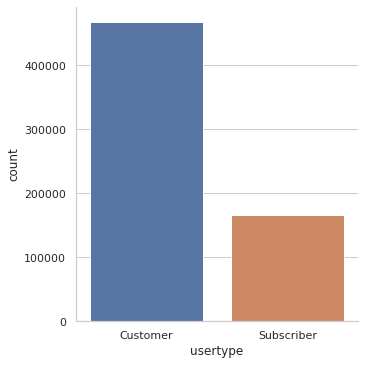

In [17]:
sns.set_theme(style="whitegrid")

usertype_plot = sns.catplot(x="usertype", kind="count", order=["Customer", "Subscriber"], data=data)

There are more one-time users of CitiBike than there are subscribers.

#### Age

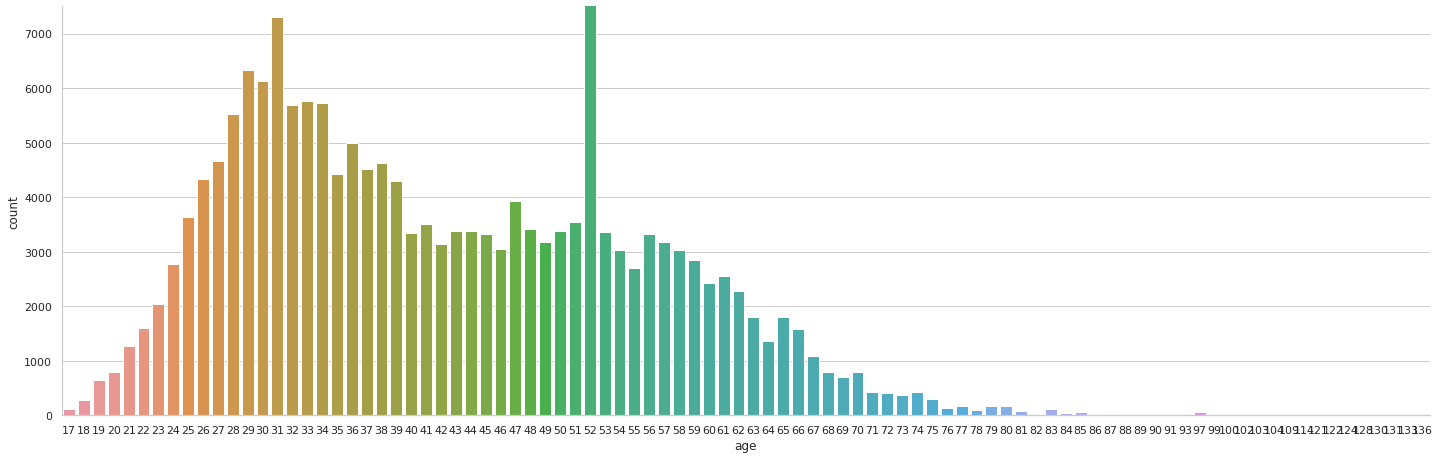

In [18]:
age_plot = sns.catplot(x="age", kind="count", data=data)
age_plot.set(ylim=(0,7500)) # Limit the maximum y-axis value because of one outlier count for age 52
age_plot.fig.set_size_inches(25, 6.5)

In [19]:
data["age"].value_counts()

52     464712
31       7312
29       6327
30       6135
33       5758
        ...  
103         2
93          2
130         2
88          2
136         1
Name: age, Length: 92, dtype: int64

#### Starting Stations

In [20]:
start_stations = data["start station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
start_stations = start_stations.nlargest(10, 'counts')
start_stations

,Station name,counts
0,1 Ave & E 68 St,4251
1,W 21 St & 6 Ave,3762
2,E 17 St & Broadway,3230
3,W 33 St & 7 Ave,3213
4,E 13 St & Avenue A,3044
5,E 33 St & 1 Ave,2970
6,Broadway & W 60 St,2757
7,Grand St & Elizabeth St,2700
8,Clinton St & Grand St,2620
9,Pershing Square North,2606


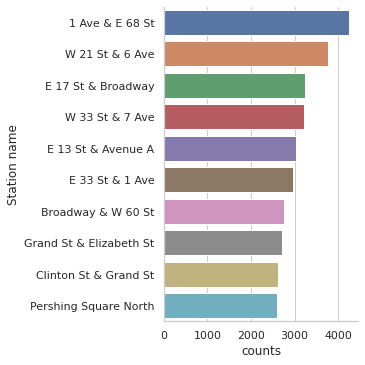

In [21]:
start_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=start_stations)

#### Ending stations

In [22]:
end_stations = data["end station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
end_stations = end_stations.nlargest(10, 'counts')
end_stations

,Station name,counts
0,1 Ave & E 68 St,4226
1,W 21 St & 6 Ave,3734
2,E 17 St & Broadway,3481
3,W 33 St & 7 Ave,3161
4,E 13 St & Avenue A,3043
5,E 33 St & 1 Ave,3004
6,Broadway & W 60 St,2789
7,Grand St & Elizabeth St,2723
8,Pershing Square North,2622
9,Clinton St & Grand St,2611


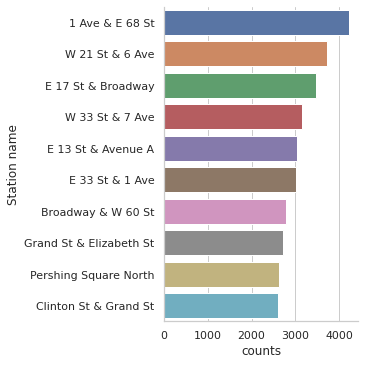

In [23]:
end_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=end_stations)

We can see from both plots that the top 10 start and end stations are consistent with each other. This indicates high taffic areas which can be potential locations for adding more bikes and bike docks. 

#### Origin-Destination Pairs

Here we create `od_trips` which contains the origin-destination pairs derived from the unique pairs of `start station name` and `end station name`.

In [24]:
## Count of rides per OD
od_trips = data.groupby(['start station name', 'end station name'], as_index=False)['bikeid'].count()
od_trips = od_trips.rename(columns={"start station name": "start", "end station name": "end", "bikeid": "total_trips"}, errors="raise")
od_trips.head()

,start,end,total_trips
0,1 Ave & E 110 St,1 Ave & E 110 St,17
1,1 Ave & E 110 St,1 Ave & E 68 St,11
2,1 Ave & E 110 St,1 Ave & E 78 St,1
3,1 Ave & E 110 St,1 Ave & E 94 St,2
4,1 Ave & E 110 St,2 Ave & E 104 St,2


In [25]:
od_trips["od"] = od_trips["start"] + " to " + od_trips["end"]
od_trips

,start,end,total_trips,od
0,1 Ave & E 110 St,1 Ave & E 110 St,17,1 Ave & E 110 St to 1 Ave & E 110 St
1,1 Ave & E 110 St,1 Ave & E 68 St,11,1 Ave & E 110 St to 1 Ave & E 68 St
2,1 Ave & E 110 St,1 Ave & E 78 St,1,1 Ave & E 110 St to 1 Ave & E 78 St
3,1 Ave & E 110 St,1 Ave & E 94 St,2,1 Ave & E 110 St to 1 Ave & E 94 St
4,1 Ave & E 110 St,2 Ave & E 104 St,2,1 Ave & E 110 St to 2 Ave & E 104 St
...,...,...,...,...
164369,Wythe Ave & Metropolitan Ave,Willoughby Ave & Tompkins Ave,2,Wythe Ave & Metropolitan Ave to Willoughby Ave...
164370,Wythe Ave & Metropolitan Ave,Willoughby Ave & Walworth St,1,Wythe Ave & Metropolitan Ave to Willoughby Ave...
164371,Wythe Ave & Metropolitan Ave,Willoughby St & Fleet St,1,Wythe Ave & Metropolitan Ave to Willoughby St ...
164372,Wythe Ave & Metropolitan Ave,Wyckoff Av & Stanhope St,1,Wythe Ave & Metropolitan Ave to Wyckoff Av & S...


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


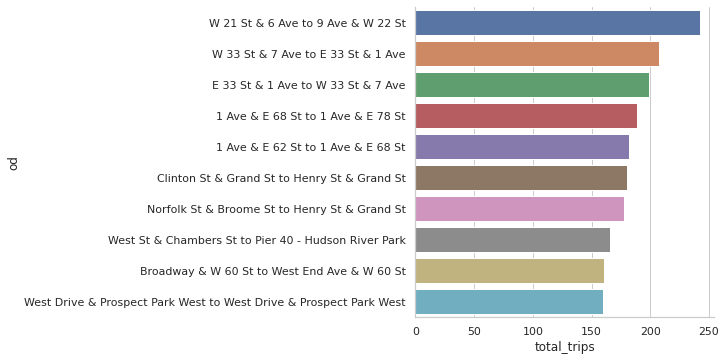

In [26]:
od_rank_plot = sns.catplot(y="od", x="total_trips", orient="h", kind="bar", data=od_trips.nlargest(10, "total_trips"))

#### Origin-Destination Matrix

In this part, we focus on analyzing the number of trips between the top 10 `start` and `end` stations. It would be impossible to visually analyze for all possible pairs because the dataset is too big.

In [27]:
# Get the trips between the top 10 stations.

od_topten = od_trips[od_trips.start.isin(start_stations["Station name"]) & od_trips.end.isin(end_stations["Station name"])]
od_topten

,start,end,total_trips,od
2318,1 Ave & E 68 St,1 Ave & E 68 St,87,1 Ave & E 68 St to 1 Ave & E 68 St
2433,1 Ave & E 68 St,Broadway & W 60 St,37,1 Ave & E 68 St to Broadway & W 60 St
2451,1 Ave & E 68 St,Clinton St & Grand St,2,1 Ave & E 68 St to Clinton St & Grand St
2482,1 Ave & E 68 St,E 13 St & Avenue A,8,1 Ave & E 68 St to E 13 St & Avenue A
2489,1 Ave & E 68 St,E 17 St & Broadway,9,1 Ave & E 68 St to E 17 St & Broadway
...,...,...,...,...
145506,W 33 St & 7 Ave,E 33 St & 1 Ave,207,W 33 St & 7 Ave to E 33 St & 1 Ave
145574,W 33 St & 7 Ave,Grand St & Elizabeth St,4,W 33 St & 7 Ave to Grand St & Elizabeth St
145621,W 33 St & 7 Ave,Pershing Square North,93,W 33 St & 7 Ave to Pershing Square North
145660,W 33 St & 7 Ave,W 21 St & 6 Ave,21,W 33 St & 7 Ave to W 21 St & 6 Ave


In [28]:
# Create a matrix

od_matrix = pd.pivot_table(od_topten, index='start', columns='end', values='total_trips', aggfunc=np.sum, fill_value=0)
od_matrix

end,1 Ave & E 68 St,Broadway & W 60 St,Clinton St & Grand St,E 13 St & Avenue A,E 17 St & Broadway,E 33 St & 1 Ave,Grand St & Elizabeth St,Pershing Square North,W 21 St & 6 Ave,W 33 St & 7 Ave
start,,,,,,,,,,
1 Ave & E 68 St,87,37,2,8,9,11,13,13,1,62
Broadway & W 60 St,35,89,1,0,6,1,1,9,2,6
Clinton St & Grand St,0,1,97,20,11,1,90,3,4,0
E 13 St & Avenue A,10,0,18,107,35,5,11,3,30,5
E 17 St & Broadway,4,3,9,46,81,22,8,20,78,13
E 33 St & 1 Ave,40,1,1,23,32,64,8,84,32,199
Grand St & Elizabeth St,1,0,96,15,15,8,70,0,16,0
Pershing Square North,31,9,3,8,20,108,0,27,11,84
W 21 St & 6 Ave,2,4,6,19,25,12,8,10,69,18


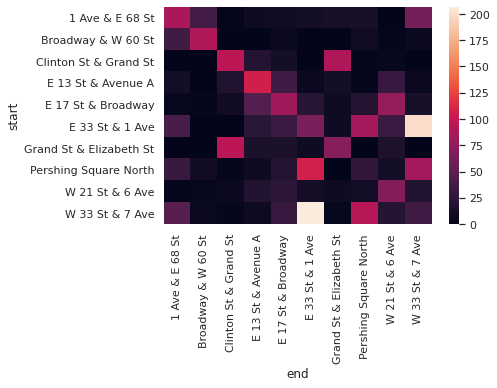

In [29]:
# Generate a heatmap

od_heatmap = sns.heatmap(od_matrix)

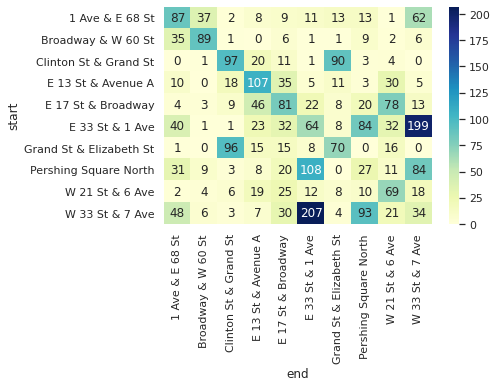

In [30]:
# Change color palette

od_heatmap = sns.heatmap(od_matrix, cmap="YlGnBu", annot=True, fmt="d")

#### Gender

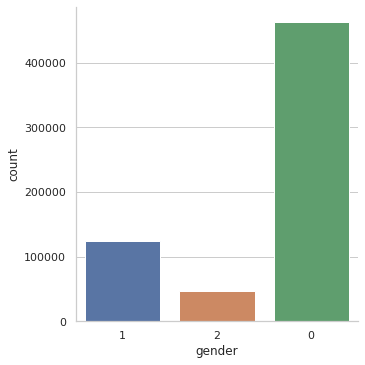

In [31]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2, 0], data=data)

It seems that the dataset contains mostly zero (0) values for the gender. We can continue our analysis by removing those trips with unknown gender.

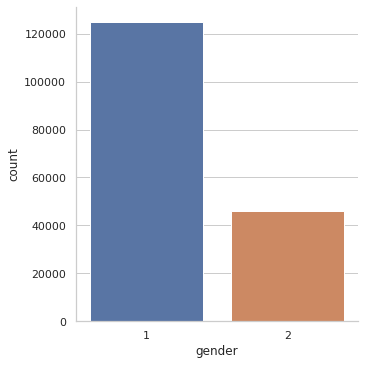

In [32]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2], data=data[data["gender"] > 0])

#### Day of week

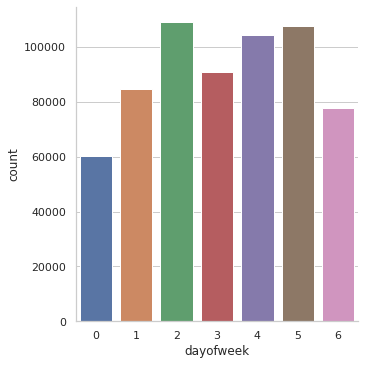

In [33]:
dow_plot = sns.catplot(x="dayofweek", kind="count", data=data)

The values for `dayofweek` starts with `0` or `Monday` and ends with `6` or `Sunday`. Based on the bar plot above, most trips happen on Wednesdays, Fridays and Saturdays.

#### Hour of day

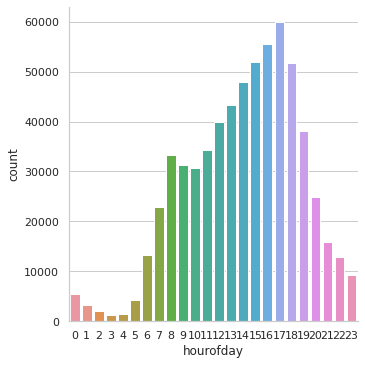

In [34]:
hod_plot = sns.catplot(x="hourofday", kind="count", data=data)

From the plot, the number of trips starts increasing from 12 noon and peaks at 5PM. 

#### Duration in minutes

In [35]:
data["duration_min"].describe()

count    634631.000000
mean         17.400660
std         201.039591
min           1.016667
25%           5.750000
50%           9.883333
75%          17.266667
max       34420.700000
Name: duration_min, dtype: float64

#### Detect and remove outliers

Outliers are defined as values that is more than 3 standard deviations away from the mean. Here, we detect them by computing the z score of each value, which is relative to the mean and standard deviation.

In [36]:
z_scores = zscore(data["duration_min"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_entries = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
duration_min_outliers = (abs_z_scores >= 3)
data[duration_min_outliers].duration_min # Show outlier values

55        3793.983333
128       4257.516667
280       1364.983333
287       3014.366667
290       3205.933333
             ...     
631214    7005.816667
632255    1363.300000
633024    5281.700000
633398    6875.366667
633877    1165.300000
Name: duration_min, Length: 624, dtype: float64

#### Histograms with KDE

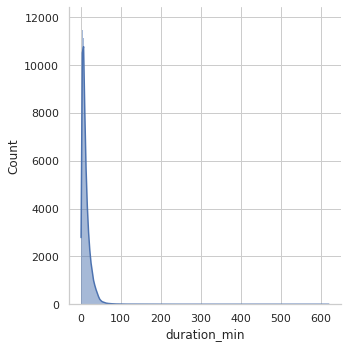

In [37]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)

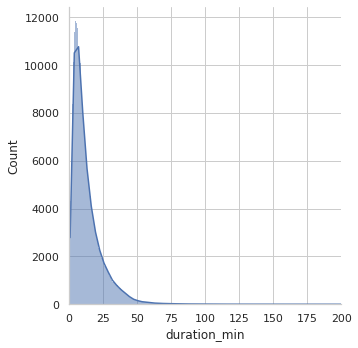

In [38]:
# Zoom in a little closer. Let's limit the x-axis to only show values up to 200

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 200))

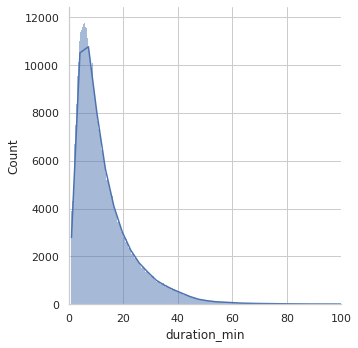

In [39]:
# Zoom in more. Let's limit the x-axis to only show values up to 100

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 100))

#### ECDF with Rug Plots

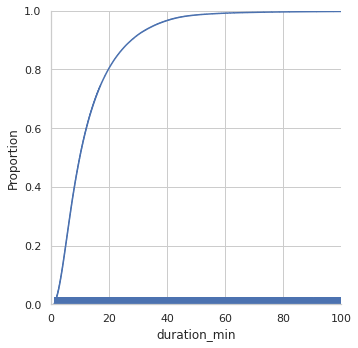

In [40]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kind="ecdf", rug=True)
duration_plot.set(xlim=(0, 100))

## 3. Examine relationships/correlations

### User type and gender

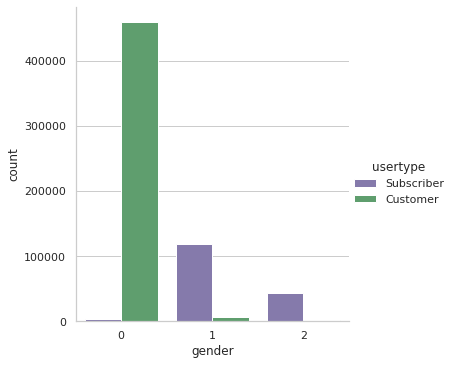

In [41]:
usertype_gender_plot = sns.catplot(x="gender", 
                                   kind="count", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   data=data)

- Users with 24-hour pass or 3-day passes did not have their gender information recorded.
- More male subscribers than females. 

### Trip distance, duration and user type

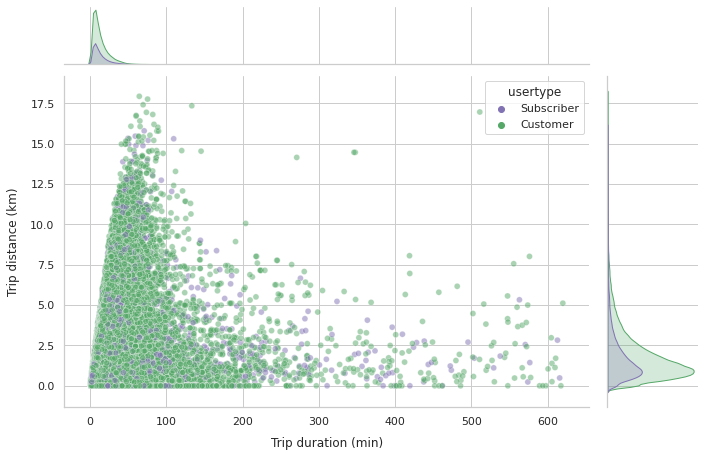

In [42]:
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

In [43]:
z_scores = zscore(data["distance_km"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_dist = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
dist_outliers = (abs_z_scores >= 3)
data[dist_outliers].distance_km # Show outlier values

72        7.559672
79        6.791290
107       7.055636
123       7.133794
287       6.816675
            ...   
634021    8.016243
634081    7.339160
634088    8.447268
634167    7.635918
634521    6.830051
Name: distance_km, Length: 11992, dtype: float64

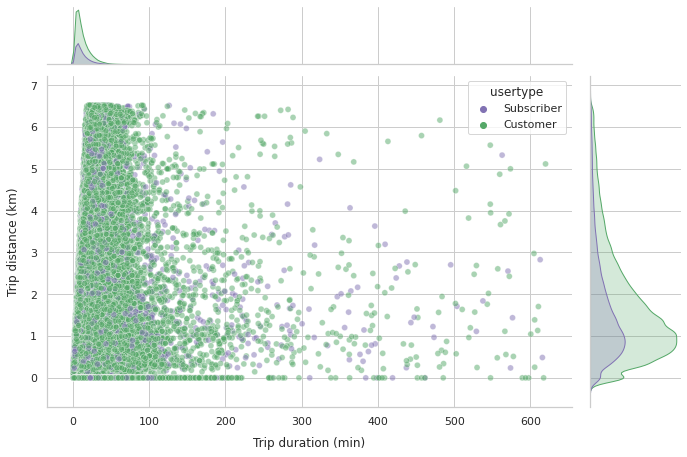

In [44]:
# Plot with outliers for both duration and distance
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries & filtered_dist], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

### Get correlation between quantitative variables

In [45]:
data_to_corr = data[["gender", "duration_min", "age", "distance_km"]]
data_to_corr

,gender,duration_min,age,distance_km
0,2,5.066667,25,0.828754
1,1,6.166667,30,0.487242
2,2,10.583333,41,0.971186
3,0,12.633333,52,2.124707
4,1,8.700000,33,1.342431
...,...,...,...,...
634626,1,2.250000,33,0.233175
634627,0,5.966667,52,0.555965
634628,0,4.816667,52,0.925453
634629,1,2.766667,35,0.632157


In [46]:
# Get z scores of the following variables
z_scores = zscore(data_to_corr[["duration_min", "age", "distance_km"]]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_rows = (abs_z_scores < 3).all(axis=1) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
data_to_corr_outliers = (abs_z_scores >= 3)
data_to_corr[data_to_corr_outliers] # Show outlier values

,gender,duration_min,age,distance_km
25,1,19.883333,21,0.000000
28,1,18.783333,23,1.313043
32,1,4.600000,23,0.835615
33,1,21.833333,22,1.009758
37,1,6.316667,21,0.872510
...,...,...,...,...
634413,1,3.650000,79,0.435061
634474,0,43.750000,21,0.814466
634478,1,23.783333,23,4.652121
634521,0,41.866667,52,6.830051


In [47]:
# Remove outliers
data_to_corr = data_to_corr[filtered_rows]

#### Correlation Heatmap

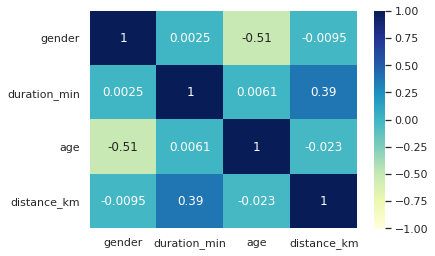

In [48]:
data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                vmin=-1, 
                                vmax=1)

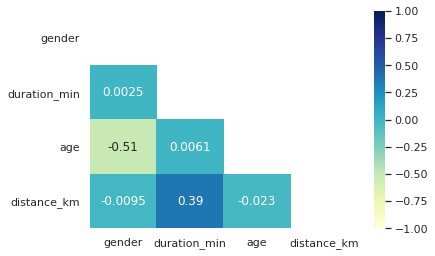

In [49]:
mask = np.triu(np.ones_like(data_to_corr.corr(), dtype=bool))

data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                mask=mask,
                                vmin=-1, 
                                vmax=1)

Variables `distance_km` and `duration_min` showed some positive correlation. We can still include them as features in a modeling task later.

----
----

# Exercise Proper: Continuation of EDA

We are already done in examining the individual characteristics of each variable in the dataset. You're task is to continue examining the remaining relationships (bivariate/multivariate) between variables. Here are some that you can prioritize:

- / Bivariate: Trip duration & time of day
- / Bivariate: User type & age
- Bivariate: Start station & user type
- Bivariate: End station & user type
- Bivariate: End station & gender
- Multi: Start station, end station & trip duration
- Multi: Start station, end station & unique users
- Multi: Start station, end station & user type
- /  Multi: Trip distance, duration & gender
- Multi: Average trip distance per unique user, average duration per unique user & user type
- Multi: Average trip distance per unique user, average duration per unique user, gender & user type

After creating simple visualizations for each, write down your observations in a separate cell. You do not have to interpret yet why those relationships appear. We're still doing EDA. Relax ;)

In [50]:
data.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
0,304,2021-02-01 00:04:23.078,2021-02-01 00:09:27.792,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2,0,0,2021,5.066667,25,0.828754
1,370,2021-02-01 00:07:08.808,2021-02-01 00:13:19.467,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1,0,0,2021,6.166667,30,0.487242
2,635,2021-02-01 00:07:55.939,2021-02-01 00:18:31.039,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2,0,0,2021,10.583333,41,0.971186
3,758,2021-02-01 00:08:42.096,2021-02-01 00:21:20.782,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0,0,0,2021,12.633333,52,2.124707
4,522,2021-02-01 00:09:32.682,2021-02-01 00:18:15.410,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1,0,0,2021,8.700000,33,1.342431


###Trip duration & time of day

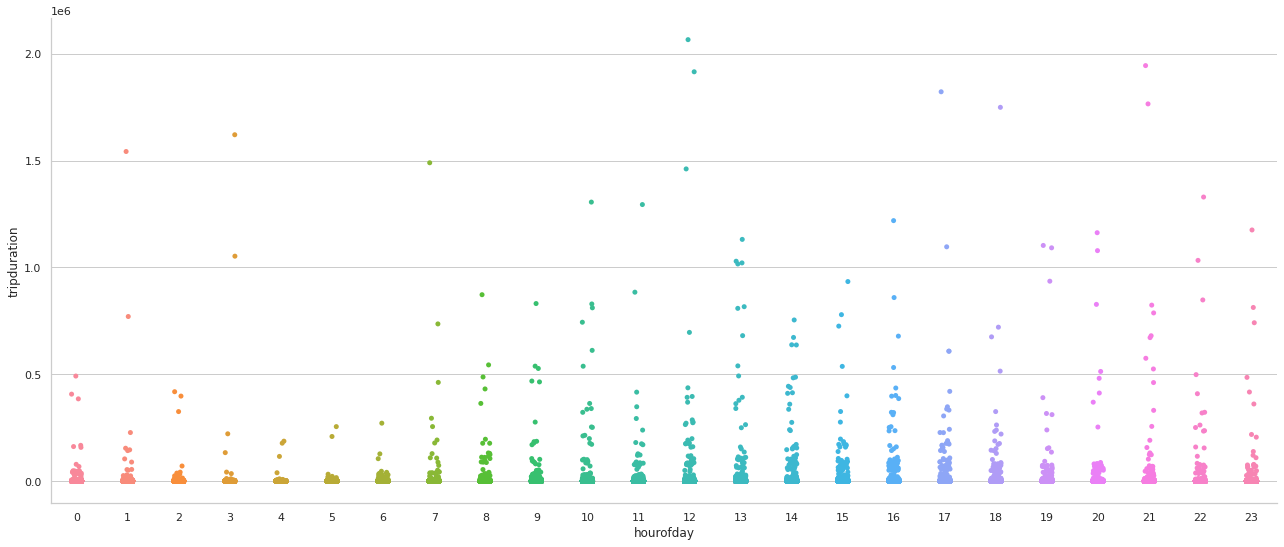

In [51]:
tripduration_timeofday = sns.catplot(x="hourofday",y="tripduration", data=data)
tripduration_timeofday.fig.set_size_inches(20,8)

The highest trip duration is during 12 noon, while the lowest is during 4 am to 6 am

###User type & age

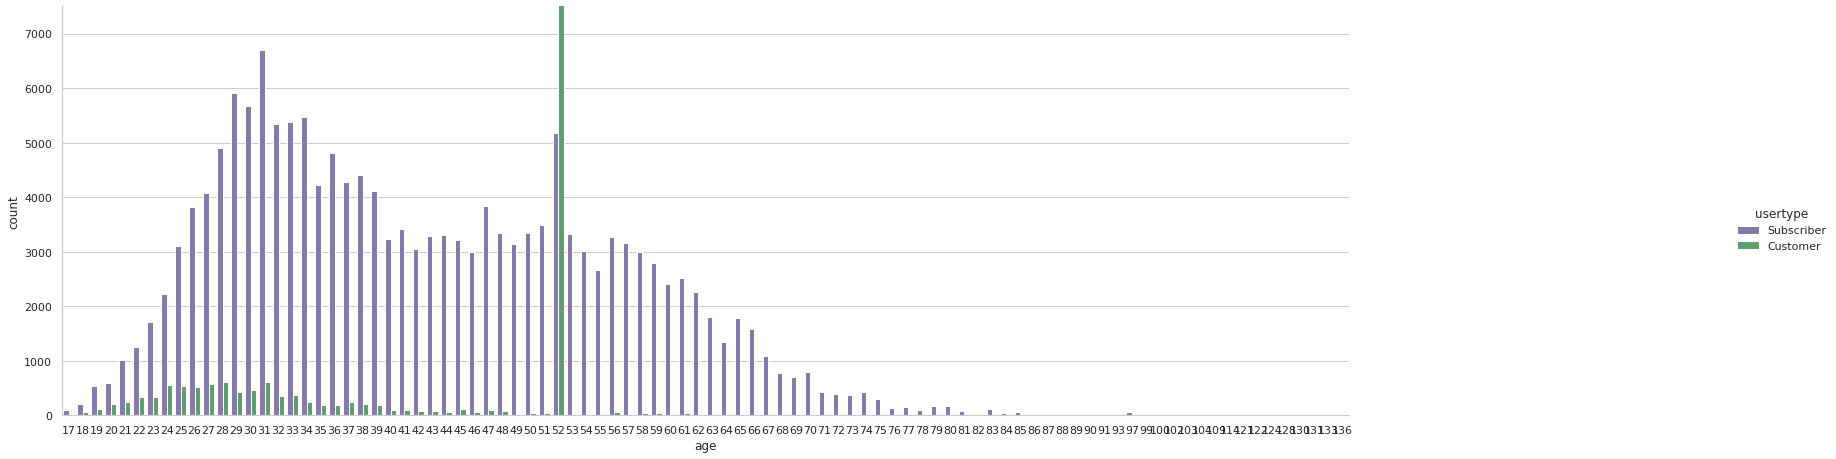

In [52]:
usertype_age_plot = sns.catplot(x="age", 
                                   kind="count", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"},
                                   data=data)
usertype_age_plot.set(ylim=(0,7500))
usertype_age_plot.fig.set_size_inches(30, 6.5)

Majority of the Customers are 52 years old while majority of the Subscribers are 31 years old.

Note: The limit for the yaxis is set to only 7500 for ease of analyzin the data.

###Start station & user type

In [53]:
start_stations = data["start station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
start_stations = start_stations.nlargest(10, 'counts')

In [54]:
data_temp = data
temp = data_temp.rename(columns={"start station name": "start"}, errors="raise")
temp_top = temp[temp.start.isin(start_stations["Station name"])]

Selected from top 10 stations by count

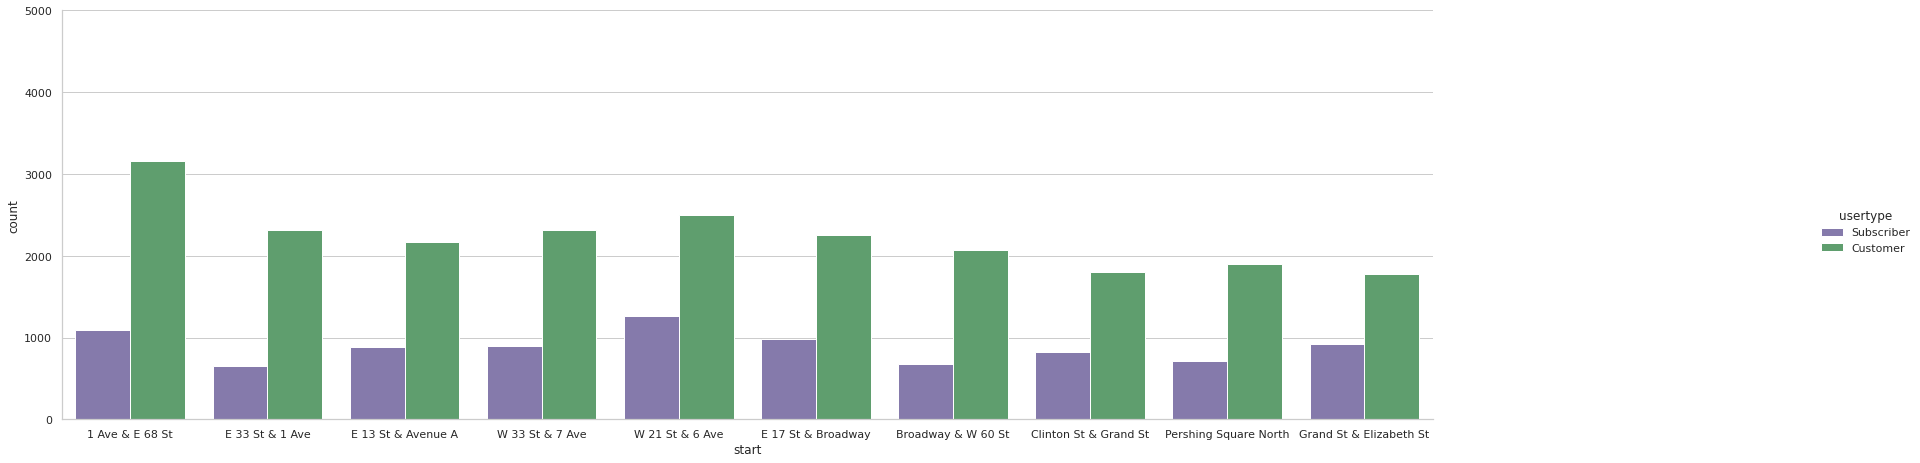

In [55]:
usertype_startstation_plot = sns.catplot(x="start", 
                                   kind="count", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"},
                                   data=temp_top)
usertype_startstation_plot.set(ylim=(0,5000))
usertype_startstation_plot.fig.set_size_inches(30, 6.5)

All of the `Start Stations` have more  `Customers` than `Subscriber` with the `1 Ave & E 68 St` having the most foot traffic.



###End station & user type

In [56]:
end_stations = data["end station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
end_stations = end_stations.nlargest(10, 'counts')

In [57]:
data_temp2 = data
temp2 = data_temp2.rename(columns={"end station name": "end"}, errors="raise")
temp_top2 = temp2[temp2.end.isin(end_stations["Station name"])]

Selected from top 10 stations by count

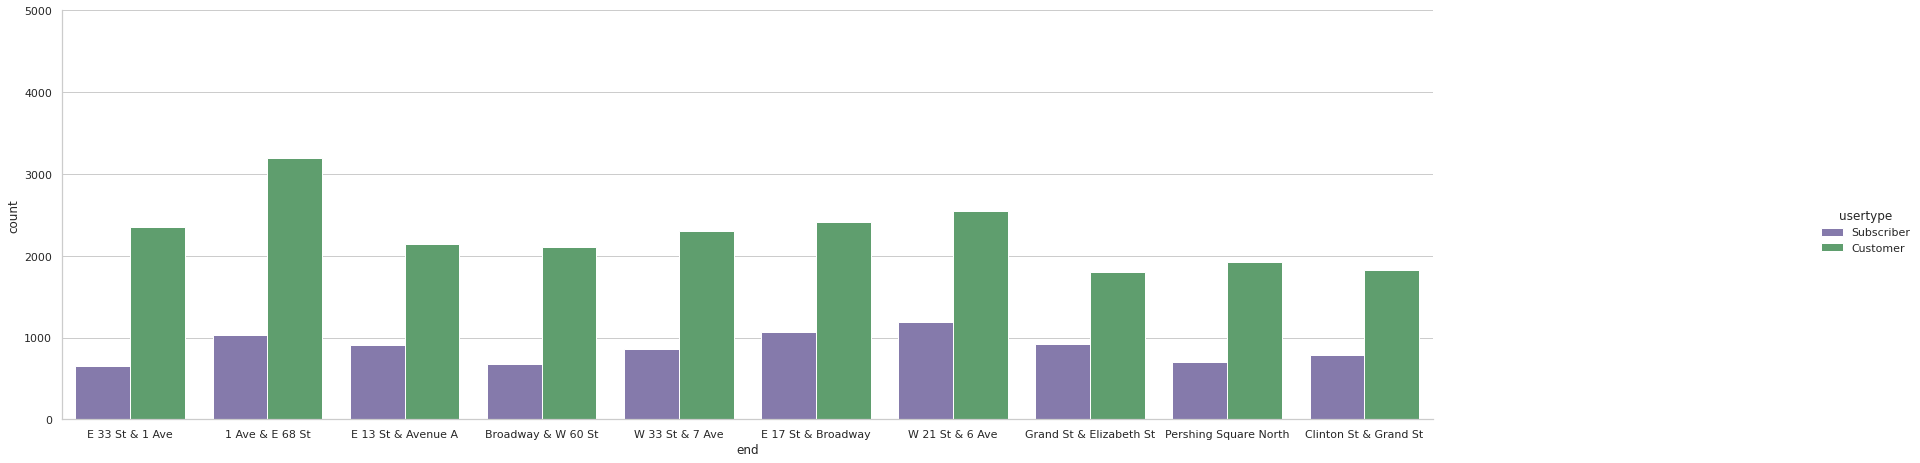

In [58]:
usertype_endstation_plot = sns.catplot(x="end", 
                                   kind="count", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"},
                                   data=temp_top2)
usertype_endstation_plot.set(ylim=(0,5000))
usertype_endstation_plot.fig.set_size_inches(30, 6.5)

Like the `Start Stations` all of the `End Stations` have more  `Customers` than `Subscriber` with the `1 Ave & E 68 St` having the most foot traffic.


###End station & gender

Selected from top 10 stations by count

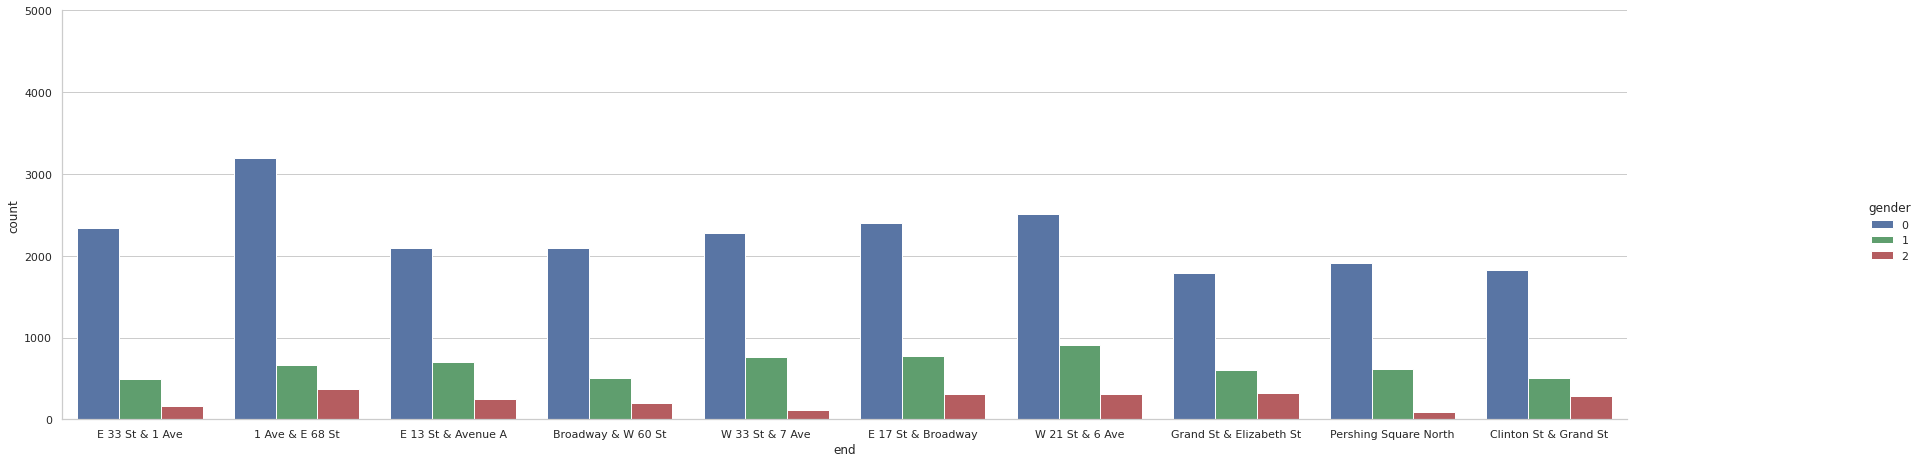

In [59]:
usertype_endstation_plot = sns.catplot(x="end", 
                                   kind="count", 
                                   hue="gender", 
                                   palette={2: "r", 1: "g", 0: "b"},
                                   data=temp_top2)
usertype_endstation_plot.set(ylim=(0,5000))
usertype_endstation_plot.fig.set_size_inches(30, 6.5)

Disregarding the unkown genders, there are more male passengers than female ones. With `W 21 St & 6 Ave` having the most male passengers and `1 Ave & E68 St` having the most female passengers

###Start station, end station & trip duration

In [60]:
temp = data
td_trips = temp.rename(columns={"start station name": "start", "end station name": "end"}, errors="raise")
td_trips.head()

,tripduration,starttime,stoptime,start station id,start,start station latitude,start station longitude,end station id,end,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
0,304,2021-02-01 00:04:23.078,2021-02-01 00:09:27.792,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2,0,0,2021,5.066667,25,0.828754
1,370,2021-02-01 00:07:08.808,2021-02-01 00:13:19.467,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1,0,0,2021,6.166667,30,0.487242
2,635,2021-02-01 00:07:55.939,2021-02-01 00:18:31.039,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2,0,0,2021,10.583333,41,0.971186
3,758,2021-02-01 00:08:42.096,2021-02-01 00:21:20.782,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0,0,0,2021,12.633333,52,2.124707
4,522,2021-02-01 00:09:32.682,2021-02-01 00:18:15.410,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1,0,0,2021,8.700000,33,1.342431


In [61]:
td_topten = td_trips[td_trips.start.isin(start_stations["Station name"]) & td_trips.end.isin(end_stations["Station name"])]
td_topten.head()

,tripduration,starttime,stoptime,start station id,start,start station latitude,start station longitude,end station id,end,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
13,6713,2021-02-01 00:20:11.229,2021-02-01 02:12:04.849,3141,1 Ave & E 68 St,40.765005,-73.958185,3141,1 Ave & E 68 St,40.765005,-73.958185,37620,Subscriber,1975,2,0,0,2021,111.883333,46,0.000000
794,1413,2021-02-03 13:38:58.396,2021-02-03 14:02:31.686,3435,Grand St & Elizabeth St,40.718822,-73.995960,3435,Grand St & Elizabeth St,40.718822,-73.995960,37785,Subscriber,2000,1,2,13,2021,23.550000,21,0.000000
808,417,2021-02-03 13:40:41.027,2021-02-03 13:47:38.909,492,W 33 St & 7 Ave,40.750200,-73.990931,519,Pershing Square North,40.751873,-73.977706,36709,Subscriber,1976,1,2,13,2021,6.950000,45,1.129436
947,2057,2021-02-03 13:59:51.577,2021-02-03 14:34:08.658,3141,1 Ave & E 68 St,40.765005,-73.958185,3141,1 Ave & E 68 St,40.765005,-73.958185,34194,Subscriber,1989,1,2,13,2021,34.283333,32,0.000000
958,89054,2021-02-03 14:01:18.728,2021-02-04 14:45:33.548,3141,1 Ave & E 68 St,40.765005,-73.958185,3141,1 Ave & E 68 St,40.765005,-73.958185,46965,Subscriber,1973,2,2,14,2021,1484.233333,48,0.000000


In [62]:
td_matrix = pd.pivot_table(td_topten, index='start', columns='end', values='tripduration', aggfunc=np.sum, fill_value=0)
td_matrix.head()

end,1 Ave & E 68 St,Broadway & W 60 St,Clinton St & Grand St,E 13 St & Avenue A,E 17 St & Broadway,E 33 St & 1 Ave,Grand St & Elizabeth St,Pershing Square North,W 21 St & 6 Ave,W 33 St & 7 Ave
start,,,,,,,,,,
1 Ave & E 68 St,163293,27634,3080,10801,13141,9497,24878,10484,1443,80099
Broadway & W 60 St,25875,209267,2309,0,9456,627,2757,6776,1912,3788
Clinton St & Grand St,0,2163,104928,10430,11192,43872,41939,4542,5247,0
E 13 St & Avenue A,11809,0,16770,112720,19936,2395,7698,2870,20982,4723
E 17 St & Broadway,6027,3524,8500,31749,76275,17274,6802,13874,37372,7097


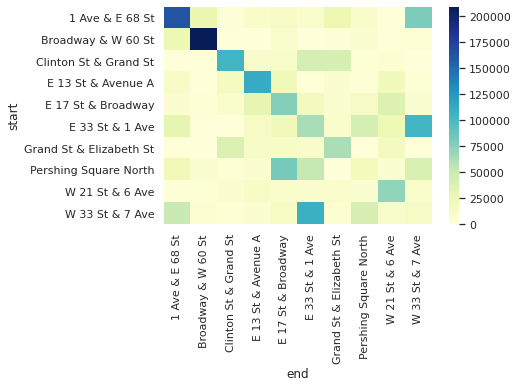

In [63]:
td_heatmap = sns.heatmap(td_matrix, cmap="YlGnBu", annot=False, fmt="d")

Disregarding the trips from the same stations, the trip duration to and from `W 33 St & 7 Ave` and `E 33 St & 1 Ave` takes the longest time. This suggests that this 2 stations are the end to end stations. There are a handful of stations which have 0 trip duration which suggests that those stations are just inside each other.


###Start station, end station & unique users


In [64]:
temp = data
td_trips = temp.rename(columns={"start station name": "start", "end station name": "end"}, errors="raise")
td_trips = td_trips[["start", "end", "bikeid"]]

In [65]:
td_trips["trips"] = td_trips["start"] + " to " + td_trips["end"]
td_trips.head()

,start,end,bikeid,trips
0,W 70 St & Amsterdam Ave,West End Ave & W 60 St,27451,W 70 St & Amsterdam Ave to West End Ave & W 60 St
1,E 77 St & 3 Ave,2 Ave & E 72 St,35000,E 77 St & 3 Ave to 2 Ave & E 72 St
2,Henry St & Grand St,E 6 St & Avenue D,49319,Henry St & Grand St to E 6 St & Avenue D
3,5 Ave & E 63 St,E 88 St & Park Ave,48091,5 Ave & E 63 St to E 88 St & Park Ave
4,6 Ave & W 33 St,E 33 St & 1 Ave,48596,6 Ave & W 33 St to E 33 St & 1 Ave


In [66]:
td_user_count =  td_trips["bikeid"].value_counts().rename_axis('Unique User ID').reset_index(name='Trip counts')
td_user_count.head(10)

,Unique User ID,Trip counts
0,49353,174
1,34650,168
2,49471,167
3,47943,166
4,47564,164
5,49560,162
6,48649,162
7,47834,162
8,47763,161
9,47845,161


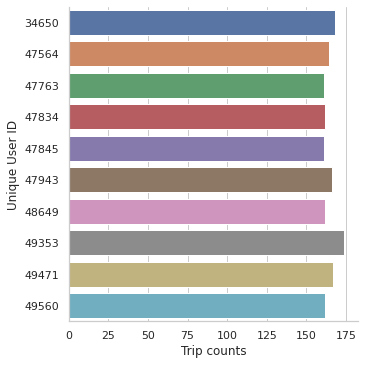

In [67]:
td_rank_plot = sns.catplot(data=td_user_count.nlargest(10,"Trip counts"), x="Trip counts", y="Unique User ID", orient="h", kind="bar")

User with the highest trip counts of 174 is the user with ID 49353

In [68]:
temp = data
td_users = temp.rename(columns={"start station name": "start", "end station name": "end"}, errors="raise")
td_users.head()

,tripduration,starttime,stoptime,start station id,start,start station latitude,start station longitude,end station id,end,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
0,304,2021-02-01 00:04:23.078,2021-02-01 00:09:27.792,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2,0,0,2021,5.066667,25,0.828754
1,370,2021-02-01 00:07:08.808,2021-02-01 00:13:19.467,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1,0,0,2021,6.166667,30,0.487242
2,635,2021-02-01 00:07:55.939,2021-02-01 00:18:31.039,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2,0,0,2021,10.583333,41,0.971186
3,758,2021-02-01 00:08:42.096,2021-02-01 00:21:20.782,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0,0,0,2021,12.633333,52,2.124707
4,522,2021-02-01 00:09:32.682,2021-02-01 00:18:15.410,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1,0,0,2021,8.700000,33,1.342431


In [69]:
td_matrix = pd.pivot_table(td_topten, index='start', columns='end', values='bikeid', aggfunc=np.sum, fill_value=0)
td_matrix.head()

end,1 Ave & E 68 St,Broadway & W 60 St,Clinton St & Grand St,E 13 St & Avenue A,E 17 St & Broadway,E 33 St & 1 Ave,Grand St & Elizabeth St,Pershing Square North,W 21 St & 6 Ave,W 33 St & 7 Ave
start,,,,,,,,,,
1 Ave & E 68 St,3535436,1473601,97765,358555,375770,476523,520696,561060,47292,2524195
Broadway & W 60 St,1451274,3620494,30640,0,217644,49563,49900,354973,84328,214243
Clinton St & Grand St,0,30640,3848442,819780,462747,48292,3695551,124791,165536,0
E 13 St & Avenue A,435984,0,736728,4391335,1396822,222538,424741,118828,1209529,216880
E 17 St & Broadway,136363,106864,388969,1848037,3308129,963146,296239,835157,3082089,530375


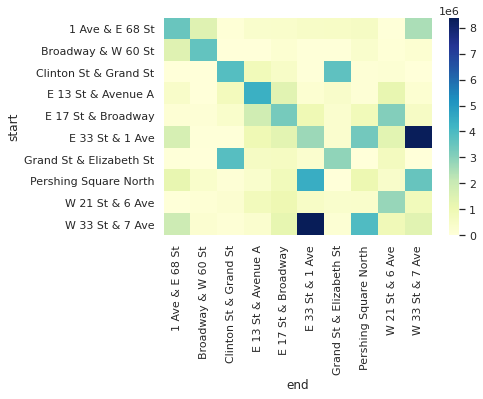

In [70]:
td_heatmap = sns.heatmap(td_matrix, cmap="YlGnBu", annot=False, fmt="d")

###Start station, end station & user type


In [71]:
temp = data
td_trips = temp.rename(columns={"start station name": "start", "end station name": "end"}, errors="raise")
td_trips["trip_stations"] = td_trips["start"] + " to " + td_trips["end"]
td_trips = td_trips[["start", "end", "trip_stations", "usertype"]]
td_trips.head()

,start,end,trip_stations,usertype
0,W 70 St & Amsterdam Ave,West End Ave & W 60 St,W 70 St & Amsterdam Ave to West End Ave & W 60 St,Subscriber
1,E 77 St & 3 Ave,2 Ave & E 72 St,E 77 St & 3 Ave to 2 Ave & E 72 St,Subscriber
2,Henry St & Grand St,E 6 St & Avenue D,Henry St & Grand St to E 6 St & Avenue D,Subscriber
3,5 Ave & E 63 St,E 88 St & Park Ave,5 Ave & E 63 St to E 88 St & Park Ave,Customer
4,6 Ave & W 33 St,E 33 St & 1 Ave,6 Ave & W 33 St to E 33 St & 1 Ave,Subscriber


In [72]:
trip_stations = td_trips["trip_stations"].value_counts().rename_axis('trip_station').reset_index(name='counts')
trip_stations = trip_stations.nlargest(5, 'counts')
trip_stations

,trip_station,counts
0,W 21 St & 6 Ave to 9 Ave & W 22 St,242
1,W 33 St & 7 Ave to E 33 St & 1 Ave,207
2,E 33 St & 1 Ave to W 33 St & 7 Ave,199
3,1 Ave & E 68 St to 1 Ave & E 78 St,189
4,1 Ave & E 62 St to 1 Ave & E 68 St,182


In [73]:
td_five = td_trips[td_trips.trip_stations.isin(trip_stations["trip_station"])]
td_five

,start,end,trip_stations,usertype
78,1 Ave & E 62 St,1 Ave & E 68 St,1 Ave & E 62 St to 1 Ave & E 68 St,Subscriber
914,W 21 St & 6 Ave,9 Ave & W 22 St,W 21 St & 6 Ave to 9 Ave & W 22 St,Subscriber
1078,W 21 St & 6 Ave,9 Ave & W 22 St,W 21 St & 6 Ave to 9 Ave & W 22 St,Subscriber
1120,W 21 St & 6 Ave,9 Ave & W 22 St,W 21 St & 6 Ave to 9 Ave & W 22 St,Subscriber
1520,W 21 St & 6 Ave,9 Ave & W 22 St,W 21 St & 6 Ave to 9 Ave & W 22 St,Subscriber
...,...,...,...,...
631830,1 Ave & E 68 St,1 Ave & E 78 St,1 Ave & E 68 St to 1 Ave & E 78 St,Customer
632701,1 Ave & E 62 St,1 Ave & E 68 St,1 Ave & E 62 St to 1 Ave & E 68 St,Subscriber
632875,1 Ave & E 68 St,1 Ave & E 78 St,1 Ave & E 68 St to 1 Ave & E 78 St,Customer
633755,1 Ave & E 62 St,1 Ave & E 68 St,1 Ave & E 62 St to 1 Ave & E 68 St,Subscriber


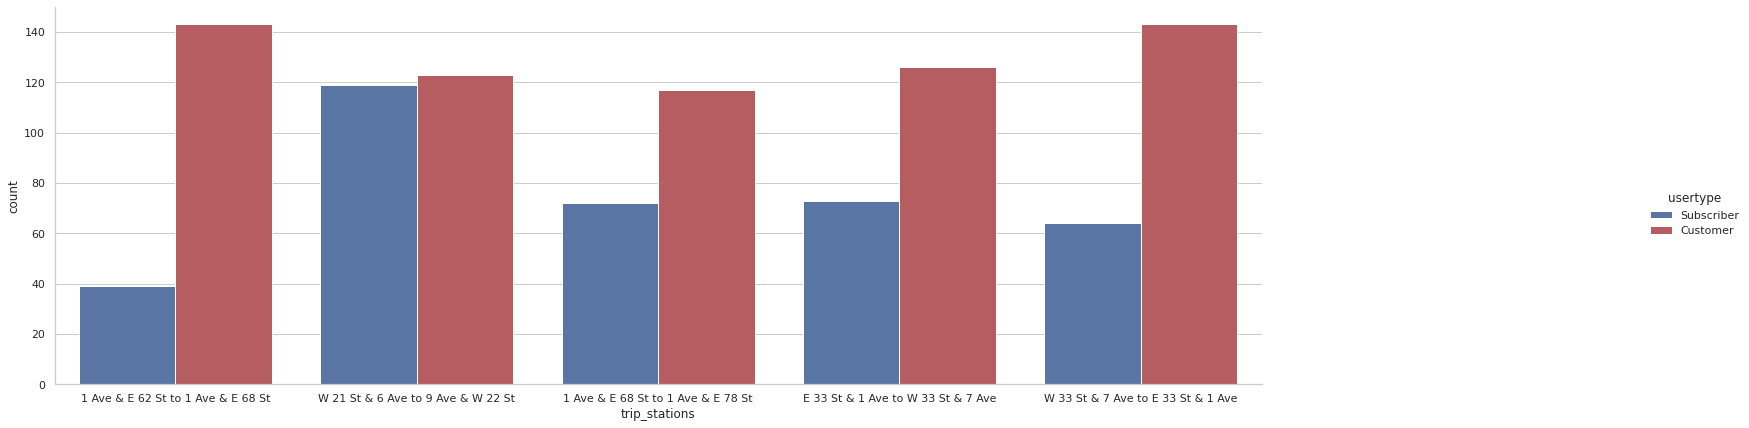

In [74]:
usertype_trip_plot = sns.catplot(x="trip_stations", 
                                   kind="count", 
                                   hue="usertype", 
                                   palette={"Customer": "r", "Subscriber": "b"},
                                   data=td_five)
usertype_trip_plot.set(ylim=(0,150))
usertype_trip_plot.fig.set_size_inches(30, 6)

Majority of the Usertypes with the top 5 most counts of trips being taken by the people are customers rather than subscribers.

###Trip distance, duration & gender

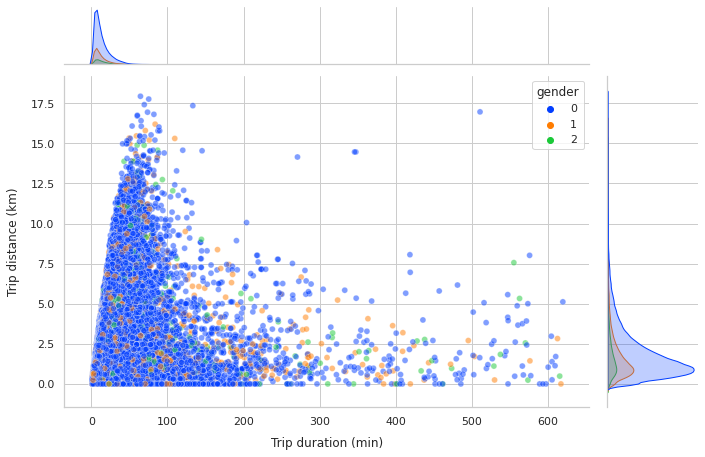

In [75]:
dur_dist_gender_plot = sns.jointplot(data=data[filtered_entries], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="gender", 
                                   palette='bright', 
                                   alpha=0.5)
dur_dist_gender_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_gender_plot.fig.set_size_inches(10.5, 6.5)

In [76]:
z_scores = zscore(data["distance_km"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_dist = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
dist_outliers = (abs_z_scores >= 3)
data[dist_outliers].distance_km # Show outlier values

72        7.559672
79        6.791290
107       7.055636
123       7.133794
287       6.816675
            ...   
634021    8.016243
634081    7.339160
634088    8.447268
634167    7.635918
634521    6.830051
Name: distance_km, Length: 11992, dtype: float64

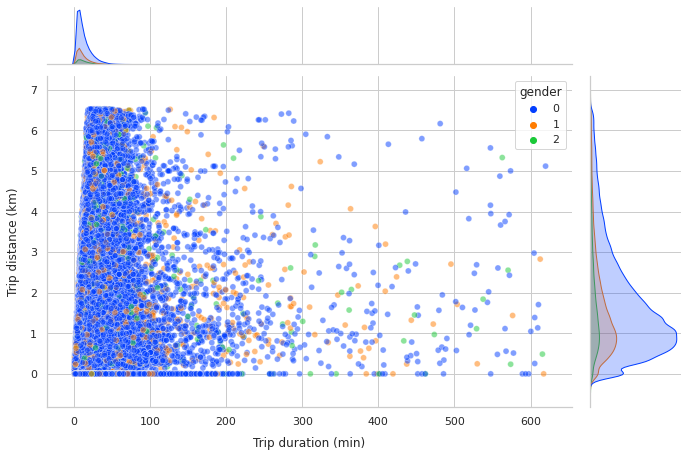

In [77]:
# Plot with outliers for both duration and distance
dur_dist_gender_plot = sns.jointplot(data=data[filtered_entries & filtered_dist], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="gender", 
                                   palette='bright', 
                                   alpha=0.5)
dur_dist_gender_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_gender_plot.fig.set_size_inches(10.5, 6.5)

There are no significant differences in the trip duration and the trip distance of male and females. Majority of the people biked for less than 100 minutes while there are only a handful who biked for more than 600 minutes.

###Average trip distance per unique user, average duration per unique user & user type

###Average trip distance per unique user, average duration per unique user, gender & user type